In [1]:
# Install Required Libraries from PyPI

!pip install face-recognition
!pip install tqdm

In [2]:
# Import Required Libraries

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import face_recognition
import tqdm

## MASK FACE ##

In [3]:
# Mathematical Function to Return Perpendicular Distance of a Point from a Line

def get_distance_from_point_to_line(point, line_point1, line_point2):

        (p,q) = point
        (x1,y1) = line_point1
        (x2,y2) = line_point2

        A = (y2-y1)
        B = (x1-x2)
        
        distance = np.abs( A*p + B*q  - A*x1 - B*y1 ) / np.sqrt( A**2 + B**2 )

        return int(distance)

In [4]:
# Mathematical Function to Return Rotated Co-ordinates of a Point around a Reference Point (Origin)

def get_point_rotation(point,origin,angle):

        (p,q) = point
        (x,y) = origin

        rotated_p = x + np.cos(angle)*(p-x) - np.sin(angle)*(q-y)
        rotated_q = y + np.sin(angle)*(p-x) + np.cos(angle)*(q-y)

        return [int(rotated_p),int(rotated_q)]

In [5]:
# Function to Wear Mask to the Human Faces found in a given Input Image 

def Mask_Faces (image_path,mask_image_path):

  masked_faces_image = Image.open(image_path)

  image = face_recognition.load_image_file(image_path)
  mask_img = Image.open(mask_image_path)

  # Get Face Landmark Co-ordinates
  face_landmarks = face_recognition.face_landmarks(image)

  # Return if no Faces found or Required Landmarks not found
  if len(face_landmarks)==0:
    # print("No Faces found in "+image_path.split('/')[-1]+" !")
    return None

  for face in face_landmarks:

    if 'nose_bridge' not in face or 'chin' not in face :
      continue

    # Nose Point (Top of Mask)
    nose_bridge = face['nose_bridge']
    nose_point = ((np.array(nose_bridge[0])+np.array(nose_bridge[1]))/2).astype(np.uint64)

    chin = face['chin']
    chin_len = len(chin)

    # Chin Points (Bottom, Left and Right of Mask)
    chin_bottom_point = np.array(chin[chin_len // 2])       
    chin_left_point = np.array(chin[chin_len // 8])        
    chin_right_point = np.array(chin[chin_len * 7 // 8])

    # Dimensions for the Mask
    width = mask_img.width
    height = mask_img.height        
    width_ratio = 1.15       
    new_mask_height = int(np.linalg.norm(nose_point - chin_bottom_point))

    # Prepare Left Half of the Mask with appropriate Size
    mask_left_img = mask_img.crop((0, 0, width // 2, height))        
    mask_left_width = get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)        
    mask_left_width = int(mask_left_width * width_ratio)        
    mask_left_img = mask_left_img.resize((mask_left_width, new_mask_height))
        
    # Prepare Right Half of the Mask with appropriate Size
    mask_right_img = mask_img.crop((width // 2, 0, width, height))        
    mask_right_width = get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)        
    mask_right_width = int(mask_right_width * width_ratio)        
    mask_right_img = mask_right_img.resize((mask_right_width, new_mask_height))

    # Join the 2 Halves to Produce the New Mask Image with the Correct Size
    new_mask_size = (mask_left_img.width + mask_right_img.width, new_mask_height)        
    new_mask_img = Image.new('RGBA', new_mask_size)        
    new_mask_img.paste(mask_left_img, (0, 0), mask_left_img)        
    new_mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

    # Calculate Angle of Rotation (Tilted Face) and Rotate the Mask
    angle_radian = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
    rotation_angle_radian = (np.pi/2) - angle_radian
    rotation_angle_degree = (rotation_angle_radian*180)/np.pi
    rotation_center = (mask_left_width,new_mask_height//2)
    rotated_mask_img = new_mask_img.rotate(rotation_angle_degree,expand=True,center = rotation_center)

    # Calcualate Co-ordinates for Pasting the Mask on the Input Image
    center_x = (nose_point[0] + chin_bottom_point[0]) // 2        
    center_y = (nose_point[1] + chin_bottom_point[1]) // 2

    mask_corner_points = [[center_x - mask_left_width, center_y - (new_mask_height//2)],
                          [center_x + mask_right_width, center_y - (new_mask_height//2)],
                          [center_x + mask_right_width, center_y + (new_mask_height//2)],
                          [center_x - mask_left_width, center_y + (new_mask_height//2)]]

    # Make Sure Image Dimentions doesn't exceed 99999 
    rotated_mask_topleft_corner = np.array([99999,99999]) 

    for point in mask_corner_points:

      rotated_mask_topleft_corner = np.minimum(rotated_mask_topleft_corner,
                                    get_point_rotation(point,(center_x,center_y),-rotation_angle_radian))

    # Paste the Mask on Image and Return it
    masked_faces_image.paste(rotated_mask_img,
                            (rotated_mask_topleft_corner[0],rotated_mask_topleft_corner[1]),
                             rotated_mask_img)

    return masked_faces_image

In [52]:
!ls

Data_Augmentation.ipynb     Mask_Images   Results
Face_Mask_Classifier.ipynb  Models	  Social_Distancing_Monitor.ipynb
LICENSE			    Pipeline.png
MainPath		    README.md


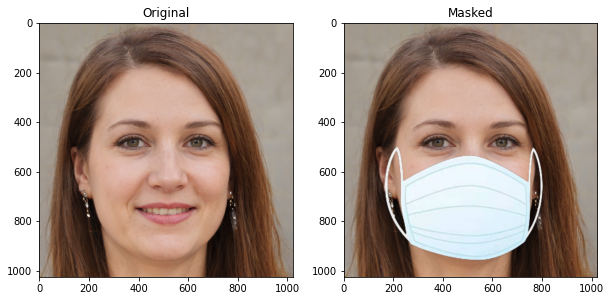

In [6]:
# Try on a single Image

FILE_PATH = "./MainPath/Training_Data/without_mask/seed0000.png"
MASK_IMAGE_PATH = "./MainPath/Mask_Images/default_mask.png"

masked_face_image = Mask_Faces(FILE_PATH,MASK_IMAGE_PATH)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(Image.open(FILE_PATH))
plt.subplot(1,2,2)
plt.title("Masked")
plt.imshow(masked_face_image)
plt.show()

In [8]:
# Function to Mask Faces present in all Images within a directory

def Generate_Masked_Images (images_path,save_path,mask_image_path):

  print("Augmenting Images, Please Wait !")

  # Loop through all the Files
  for file_name in tqdm.notebook.tqdm(os.listdir(images_path)):

    # Mask and Save in the Specified save_path
    try:

      masked_face_image = Mask_Faces(os.path.join(images_path,file_name),mask_image_path)
      masked_face_image.save(os.path.join(save_path,file_name.split('.')[0]+"_masked."+
                                          file_name.split('.')[-1]))
    except:
      continue

  print("Done !")

In [11]:
# Call the Function for a Directory
INPUT_DIR = "./MainPath/Training_Data/without_mask"
SAVE_DIR = "./MainPath/Training_Data/augmented"
MASK_IMAGE_PATH = "./MainPath/Mask_Images/default_mask.png"

#Generate_Masked_Images (INPUT_DIR,SAVE_DIR,MASK_IMAGE_PATH)

## BLURRING EFFECTS ##

In [9]:
# Define Blurring Kernel Size Ranges, a Random Size would be chosen in the Specified Ranges
# Greater the Size, Higher is the Blurring Effect (Adjustments can be made according to the needs)

motion_blur_kernel_range = (6,10)  
average_blur_kernel_range = (3,9)
gaussian_blur_kernel_range = (3,10)

In [10]:
# Set Blurring Kernels to Use and their associated Probabilities

Blurring_Kernels = ["none","motion","gaussian","average"]
Probs = [0.1,0.4,0.25,0.25]

In [12]:
# Add Motion Blur to an Image in a Random Direction

def motion_blur(img):

  # Choose a Random Kernel Size
  kernel_size = np.random.randint(motion_blur_kernel_range[0],motion_blur_kernel_range[1])
  kernel = np.zeros((kernel_size, kernel_size))

  # Random Selection of Direction of Motion Blur
  types = ["vertical","horizontal","main_diagonal","anti_diagonal"]
  choice = np.random.choice(types)

  if choice=="vertical":
    kernel[:,int((kernel_size-1)/2)] = np.ones(kernel_size)/kernel_size
  
  elif choice=="horizontal":
    kernel[int((kernel_size-1)/2),:] = np.ones(kernel_size)/kernel_size
  
  elif choice=="main_diagonal":
    
    for i in range(kernel_size):
      kernel[i][i] = 1/kernel_size

  elif choice=="anti_diagonal":

    for i in range(kernel_size):
      kernel[i][kernel_size-i-1] = 1/kernel_size

  # Convolve and Return the Blurred Image
  return cv2.filter2D(img,-1,kernel)

In [13]:
# Add a Random Blur Effect to an Image with a Random Kernel Size (in the Specified Ranges)

def get_blurred_picture(img_path):
  
  # Randomly choose a Blurring Technique
  choice = np.random.choice(Blurring_Kernels,p=Probs)

  # Load Image
  img = cv2.imread(img_path)

  if choice=="none":

    random_blurred_img = img

  elif choice=="motion":
  
    random_blurred_img  = motion_blur(img)

  elif choice=="gaussian":

    kernel_size = np.random.randint(gaussian_blur_kernel_range[0],gaussian_blur_kernel_range[1])

    if kernel_size%2==0:
      kernel_size-=1
    
    random_blurred_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

  elif choice=="average":
  
    kernel_size = np.random.randint(average_blur_kernel_range[0],average_blur_kernel_range[1])
    random_blurred_img = cv2.blur(img,(kernel_size,kernel_size))

  # Return Blurred Image  
  return random_blurred_img

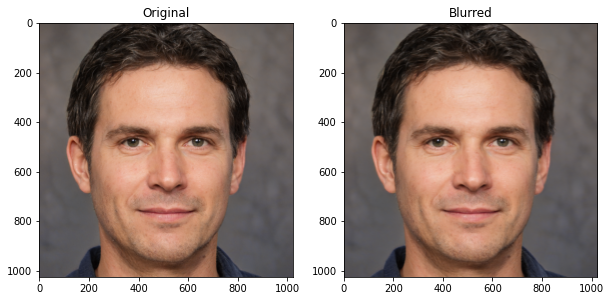

In [16]:
# Try on a single Image

FILE_PATH = "./MainPath/Training_Data/without_mask/seed0020.png"

blurred_image = get_blurred_picture(FILE_PATH)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(Image.open(FILE_PATH))
plt.subplot(1,2,2)
plt.title("Blurred")
plt.imshow(blurred_image[:,:,::-1])
plt.show()

In [17]:
# Function to Randomly Blur all Images within a directory

def Blur_Images (images_path,save_path):

  print("Blurring Images, Please Wait !")

  # Loop through all the Files
  for file_name in tqdm.notebook.tqdm(os.listdir(images_path)):

    # Mask and Save in the Specified save_path
    try :

      blurred_image = get_blurred_picture(os.path.join(images_path,file_name))
      cv2.imwrite(os.path.join(save_path,file_name.split('.')[0]+"_blurred."+\
                                         file_name.split('.')[-1]),blurred_image)  
    except:
      continue

  print("Done !")

In [18]:
# Call the Function for a Directory

INPUT_DIR = "drive/My Drive/Social_Distancing_with_AI/Training_Data/without_mask"
SAVE_DIR = "drive/My Drive/Social_Distancing_with_AI/Training_Data/augmented"

#Blur_Images (INPUT_DIR,SAVE_DIR)